Imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Config

In [15]:
labeled_path = "../data/labels.parquet"

Loading Dataset

In [3]:
dataset = pd.read_parquet(labeled_path)
dataset.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


Evaluation

Generate temporary predicted Data

In [4]:
def generate_temporary_prediction(dataset):
    predicted_demand = dataset.Demand.shift(1)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Demand'] = predicted_demand
    return predicted_data


In [5]:
predicted_data = generate_temporary_prediction(dataset)
predicted_data = predicted_data.dropna()
predicted_data.head()

,Location,Date,Demand
1,1,2023-01-02,40.0
2,1,2023-01-03,31.0
3,1,2023-01-04,27.0
4,1,2023-01-05,7.0
5,1,2023-01-06,15.0


calculate loss functions

In [43]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_loss_mape(actual_data, predicted_data, fix_inf = 1):
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    fix_inf_val = np.where(losses_df['actual_demand']==0, fix_inf, losses_df['actual_demand'])    
    losses_df['error'] = ((np.abs(losses_df['actual_demand']-losses_df['predicted_demand']))/
                          (losses_df['actual_demand']+fix_inf_val))*100

    loss_per_location = losses_df.groupby('Location').agg({'error':'mean'})
    loss_per_date = losses_df.groupby('Date').agg({'error':'mean'})
    return loss_per_location, loss_per_date


In [44]:
loss_per_location, loss_per_date = calculate_loss_mape(dataset, predicted_data)
loss_per_location.head()

,error
Location,
1,28.647898
2,30.833333
3,68.805556
4,42.190355
5,63.888889


In [45]:
loss_per_date.head()

,error
Date,
2023-01-01,6750.540743
2023-01-02,70.710765
2023-01-03,28.132564
2023-01-04,29.580036
2023-01-05,27.390765


Plot accuracies function

In [73]:
def plot_acc(losses: pd.DataFrame, label):
    ax = losses.plot.bar(rot=0)
    plt.xlabel(str(label))
    plt.ylabel('Loss(mape)')
    title = 'Model Accuracy per '+ str(label)
    plt.legend("error")
    plt.title(title)
    plt.show()


Evaluate Model function

In [68]:
def prepare_report(losses: pd.DataFrame, plot_label):
    min_threshold = losses.min()['error']
    max_threshold = losses.max()['error']
    mean_threshold = losses.mean()['error']

    report_dict = {
            'best_accuracy': min_threshold,
            'best_accuracy_point': [losses['error'].idxmin()],
            'worst_accuracy': max_threshold,
            'worst_accuracy_point': [losses['error'].idxmax()],
            'mean_accuracy': mean_threshold
        }
    losses = pd.DataFrame(np.where(losses>120, 120, losses))
    plot_acc(losses, plot_label)

    return report_dict

In [69]:
def evaluate_model(dataset, predicted_data):
    loss_per_location, loss_per_date = calculate_loss_mape(dataset, predicted_data)
    date_report_df = pd.DataFrame(prepare_report(loss_per_date, 'date'))
    loc_report_df = pd.DataFrame(prepare_report(loss_per_location, 'location'))
    return(date_report_df, loc_report_df)
    

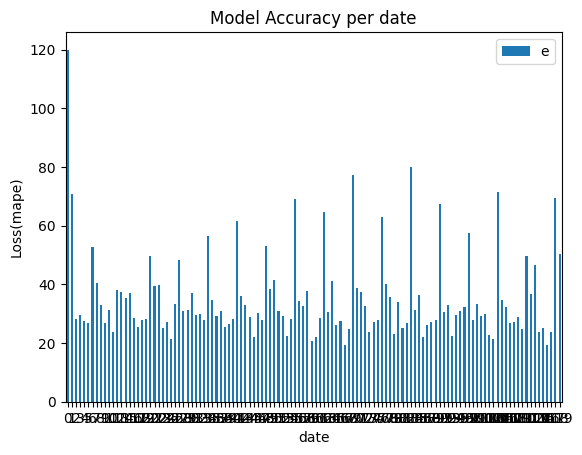

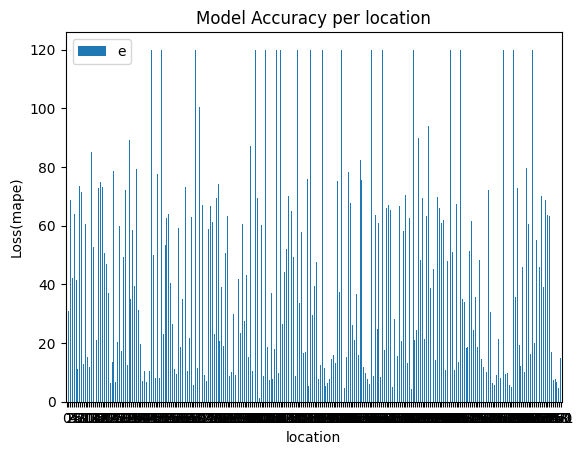

In [74]:
date_report_df, loc_report_df = evaluate_model(dataset, predicted_data)

In [13]:
print("date\n",date_report_df,"\nlocation\n", loc_report_df)

date
    best_accuracy best_accuracy_point  worst_accuracy worst_accuracy_point  \
0       19.35741          2023-03-09     6750.540743           2023-01-01   

   mean_accuracy  
0       90.72366   
location
    best_accuracy  best_accuracy_point  worst_accuracy  worst_accuracy_point  \
0           1.25                  105     2794.583333                   187   

   mean_accuracy  
0      90.509859  
